# 注意力汇聚：Nadaraya-Watson 核回归

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

## 生成数据集

In [3]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [4]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'], xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

## 平均汇聚
基于平均汇聚来计算所有训练样本输出值的平均值
$f(x) = \frac{1}{n} * ∑_{i=1}^{n} x_i$

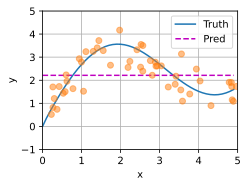

In [5]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

## 非参数注意力汇聚
$f(x) = ∑_{i=1}^{n} \frac{K(x-x_i)}{∑_{j=1}^{n} K(x-x_j)} y_i$

改写成更加通用的注意力汇聚

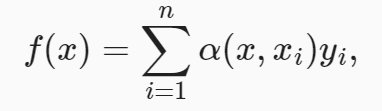

考虑一个高斯核

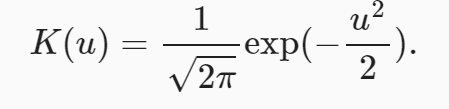

带入高斯核

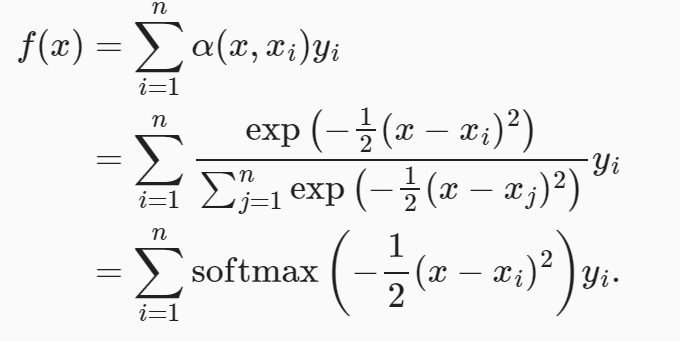

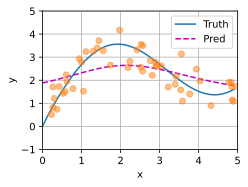

In [6]:
# 每一行都包含着相同的测试输入（例如：同样的查询）(n_test,n_train)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# 计算注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# 使用注意力权重对 y_train 进行加权
y_hat = torch.matmul(attention_weights, y_train)
# 绘制核回归图形
plot_kernel_reg(y_hat)

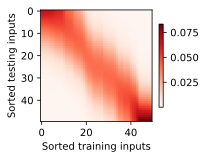

In [7]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), 
                  xlabel='Sorted training inputs',  ylabel='Sorted testing inputs')

## 带参数注意力汇聚
在下面的查询$x$和键$x_i$之间的距离乘以可学习参数$w$

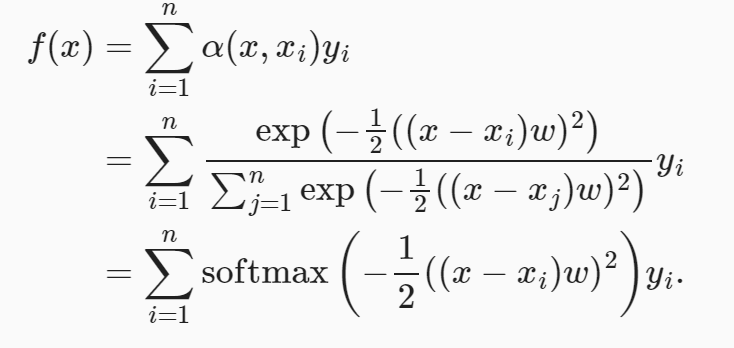

### 批量矩阵乘法

In [8]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [9]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

### 定义模型

In [15]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))  # 初始化可训练参数 w

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1) 


### 训练

In [11]:
# tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入/输出
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))

# 通过排除对角线元素创建 keys 和 values ('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

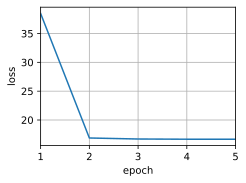

In [12]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

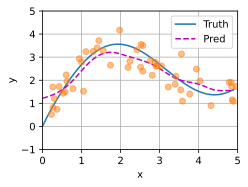

In [13]:
# keys / values的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

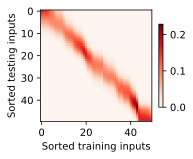

In [14]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs', ylabel='Sorted testing inputs')